In [177]:
# figure out geo
# make signal grid at some spacing
# understand x and y mapping
# C_f and R (Tau and also V) ... check units and order of magnitude
# calculate pos res
# plot it

V = 300e3/ 1000
print(V)

300.0


In [ ]:
def calc_pos_res(): # FWHM
    d = 0.05 # in mm
    # typical signal series noise after digitization= 3keV RMS or 7 keV FWHM
    interaction_energy = 500 # keV
    SNR = interaction_energy / 
    dx = 2.354 * d / (SNR * np.sqrt(chi2))

In [3]:
# figure out geometry - get right number of strips, right dimemsions

# put cuts on the x and y and get the real interaction positions fed i, check energies. 3 * 0.5mm = 1.5 mm
# somehow pass the number of interactions per strip from G4 to adl3 to here (separate text file?)

# make a set of sample signals in a grid under center strip (only a column for starters)

# construct an event and process it

# check noise level (20 mV?)

# add blurring (moving avg window in adl3)

# construct a chain of events, save it

# be able to spot/ separate events, reject pile-up with an estimate of the fraction of those

# do the chi2 for all strips comparison

# calculate the posres via ren's method

# QUESTIONS
# cut out edges for convolution relics
# why doesnt decay correction come back up to 100% of signal
# decay time constant
# max preamp out amplitude is V(0) = Q/C_f
# signal shapes vs height
# best way to do amplitude and shifting adjustments
# combining chi2 for many strips
# sum the interactions into one energy weighted point per strip range !! (also for checking reconstruction...)
# normalizing basis signals or cycling trhough amplitudes... ???

In [5]:
from __future__ import division, print_function
from math import floor
import numpy as np
import matplotlib.pyplot as plt
import sys
import scipy.stats as stats
import lmfit
import time

In [130]:
def ImportBaseSignals():
    data = np.zeros((150, 301 * 4)) #150 in z, 4 strips * 301 samples
    for i in range(0, 150, 1):
        i = int(i)
        filename = "./test/Strip_SS_" + str(i) + ".txt"
        rawdata = np.genfromtxt(filename, skip_header=1)
        strip0 = rawdata[:,6:7]
        strip1 = rawdata[:,7:8]
        strip2 = rawdata[:,8:9]
        strip3 = rawdata[:,9:10]
        allstrips = np.concatenate((strip0, strip1, strip2, strip3)).flatten()
        data[i] = allstrips
        
    return data

In [131]:
base_data = ImportBaseSignals()

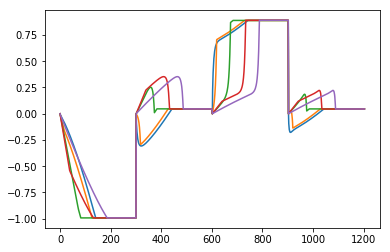

In [144]:
plt.plot(base_data[0])
plt.plot(base_data[10])
plt.plot(base_data[50])
plt.plot(base_data[100])
plt.plot(base_data[149])
plt.show()

In [145]:
xerror = 0.02

In [146]:
def moving_avg_filter(x): #(smooths with width of 1, 3 times)
    x = x.flatten()
    N = 3
    length = len(x)
    # print(len(x))
    x = np.convolve(x, np.ones((N,))/N, mode='same')
    x[length -1] = x[length -2]
    # print(len(x))
    return x

def add_noise(sig, dV):
    noise = np.random.normal(0,dV,len(sig))
    sig = sig + noise
    return sig

tau = 4400
def add_exp_decay(sig):
    #sig = np.multiply(sig, 1000)
    for i in range(0, len(sig) ,1):
        sig[i] = sig[i] * np.exp(-i/tau)
    return sig

def baseline_correction(data):
    n_data = len(data)
    baseline_correction_value = np.mean(data[0:99])
    for i in range(0, n_data, 1):
        data[i] = data[i] - baseline_correction_value
    return data

def decay_correction(data, tau):
    decay_corrected = []
    decay_correction = []
    for i in range(1, len(data), 1):
        decay = np.sum(data[1:i-1])
        decay_correction.append(decay)
        decay_corrected.append(data[i] + decay / tau)
    decay_corrected.append(data[i-1])
    return decay_corrected

In [166]:
def MakeTestSignals():
    data = np.zeros((150, 301 * 4)) #150 in z, 4 strips * 301 samples
    for i in range(0, 150, 1):
        i = int(i)
        filename = "./test/Strip_SS_" + str(i) + ".txt"
        rawdata = np.genfromtxt(filename, skip_header=1)
        strip0 = rawdata[:,6:7]
        strip1 = rawdata[:,7:8]
        strip2 = rawdata[:,8:9]
        strip3 = rawdata[:,9:10]
        strip0 = moving_avg_filter(strip0)
        strip0 = moving_avg_filter(strip0)
        strip0 = add_noise(strip0, 0.020)
        strip1 = moving_avg_filter(strip1)
        strip1 = moving_avg_filter(strip1)
        strip1 = add_noise(strip1, 0.020)
        strip2 = moving_avg_filter(strip2)
        strip2 = moving_avg_filter(strip2)
        strip2 = add_noise(strip2, 0.020)
        strip3 = moving_avg_filter(strip3)
        strip3 = moving_avg_filter(strip3)
        strip3 = add_noise(strip3, 0.020)
        allstrips = np.concatenate((strip0, strip1, strip2, strip3)).flatten()
        # print(allstrips.size)
        # print(data.size)
        # print(data.shape)
        # print(data[i].size)
        # allstrips = add_exp_decay(sig)
        # allstrips = decay_correction(sig, 4400)
        data[i] = allstrips
        
    return data

In [167]:
test_data = MakeTestSignals()

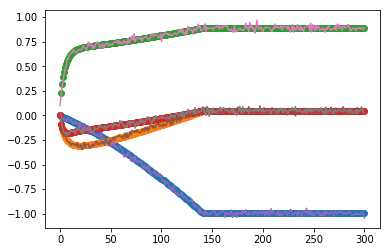

1204


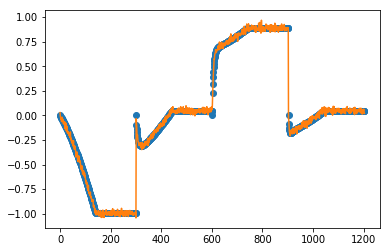

In [168]:
plt.plot(base_data[0][0:301], 'o')
plt.plot(base_data[0][301:602], 'o')
plt.plot(base_data[0][602:903], 'o')
plt.plot(base_data[0][903:1204], 'o')
plt.plot(test_data[0][0:301])
plt.plot(test_data[0][301:602])
plt.plot(test_data[0][602:903])
plt.plot(test_data[0][903:1204])
plt.show()
print(len(base_data[0]))
plt.plot(base_data[0], 'o')
plt.plot(test_data[0])
plt.show()

In [169]:
def shift_signal(sig0, sig1):
    # sig0 = ref signal
    # sig1 = one being compared
    #0.1 * np.amax(sig1) #TODO
    chisq_list = []
    sig = sig1
    #print(sig)
    chi_squared = np.sum(((sig-sig0)/xerror)**2)
    chisq_list.append(chi_squared)
    sigout = sig1
    chisq = chi_squared
    for amp in [0]: # TODO
        #sig0 = sig0 * amp
        #amp = np.amax(sig1)
        for i in range(1, int(len(sig1) / 4), 1):  # shift to larger times
            sig = list(np.linspace(0, sig1[0], i))
            sig.extend(sig1[0:-(i)])
            chi_squared = round(np.sum(((sig-sig0)/xerror)**2),5)
            chisq_list.append(chi_squared)
            if chi_squared < chisq:
                sigout = sig
                chisq = chi_squared
                #print(amp)
                #print('chi squared ', chi_squared)
        #plt.figure(60)
        #plt.title('improved with right shift')
        #plt.plot(sig0, 'b-', linewidth=7.0, alpha=0.5,label='base')
        #plt.plot(sig1, 'g-', linewidth=5.0, alpha=0.5,label = 'original')
        #plt.plot(sig, 'r--', linewidth=3.0, alpha=0.5, label = 'shifted')
        #plt.legend()
        #plt.show()
        for i in range(1, int(len(sig1) / 4), 1):  # shift to smaller times
            sig = list(sig1[(i):])
            sig.extend([float(sig1[-1])] * (i))
            chi_squared = np.sum(((sig-sig0)/xerror)**2)
            chisq_list.append(chi_squared)
            #print(' chi_sq ', chi_squared)
            if chi_squared == min(chisq_list):
                #print('hhbba')
                #print(i)
                #print(sigout)
                sigout = sig
                chisq = chi_squared
        #plt.title('improved with left shift')
        #plt.plot(sig0, 'b-', linewidth=7.0, alpha=0.5, label = 'basis')
        #plt.plot(sig1, 'g-', linewidth=5.0, alpha=0.5,label = 'original')
        #plt.plot(sig, 'r--', linewidth=3.0, alpha=0.5, label = 'shifted')
        #plt.legend()
        #plt.show()
    ##plt.figure(60)
    ##plt.title('final')
    ##plt.plot(sig0, 'b-', linewidth=7.0, alpha=0.5, label = 'basis')
    ##plt.plot(sig1, 'g-', linewidth=5.0, alpha=0.5,label = 'original')
    ##plt.plot(sigout, 'r--', linewidth=3.0, alpha=0.5, label = 'shifted')
    ##plt.legend()
    ##plt.show()
    return sigout, chisq
         #chisq_list = []
    #print('final chi_sq ', chisq)
#    plt.plot(sig0, 'b-', linewidth=7.0, alpha=0.5, label = 'basis')
 #   plt.plot(sig1, 'g-', linewidth=5.0, alpha=0.5,label = 'original')
  #  plt.plot(sigout, 'r--', linewidth=3.0, alpha=0.5, label = 'shifted')
   # plt.legend()
   # plt.show()
   # return sigout, chisq

In [171]:
def Chi2OneSignal(sig_raw, plot=True):
    chi2_values = []
    # amp = np.amax(sig_raw)
    # sig_raw = sig_raw / amp # normalize input signal
    
    for i in range(0, len(base_data), 1): # i  event number, j = strip number, 
        sig_ref = base_data[i, 0:]

        strip0_ref = sig_ref[0:301]
        strip1_ref = sig_ref[301:602]
        strip2_ref = sig_ref[602:903]
        strip3_ref = sig_ref[903:1204]
        
        strip0 = sig_raw[0:301]
        strip1 = sig_raw[301:602]
        strip2 = sig_raw[602:903]
        strip3 = sig_raw[903:1204]
        
        strip0, chi2 = shift_signal(strip0_ref, strip0) # does time and amplitude
        strip1, chi2 = shift_signal(strip1_ref, strip1) # does time and amplitude
        strip2, chi2 = shift_signal(strip2_ref, strip2) # does time and amplitude
        strip3, chi2 = shift_signal(strip3_ref, strip3) # does time and amplitude
        
        sig = np.concatenate((strip0, strip1, strip2, strip3)).flatten()
        
        chi_squared = np.sum(((sig_ref-sig)/xerror)**2)
        chi_squared = np.round(chi_squared, 5)
        
        chi2_values.append(chi2)
        
        if plot == True:
            print(chi2)
            plt.figure(1)
            plt.plot(sig_ref, 'b-', linewidth=7.0, alpha=0.5, label = 'basis')
            plt.plot(sig_raw, 'g-', linewidth=5.0, alpha=0.5,label = 'original')
            plt.plot(sig, 'r--', linewidth=3.0, alpha=0.5, label = 'shifted')
            plt.text(0, 0.1, chi2) 
            plt.legend()
            plt.savefig('test1.pdf')
            plt.show()
        
    i = np.argmin(chi2_values)
    
    print('index ', i)
    
    sig_ref = base_data[i, 0:]sh
    
    strip0_ref = sig_ref[0:301]
    strip1_ref = sig_ref[301:602]
    strip2_ref = sig_ref[602:903]
    strip3_ref = sig_ref[903:1204]
        
    strip0 = sig_raw[0:301]
    strip1 = sig_raw[301:602]
    strip2 = sig_raw[602:903]
    strip3 = sig_raw[903:1204]
        
    strip0, chi2 = shift_signal(strip0_ref, strip0) # does time and amplitude
    strip1, chi2 = shift_signal(strip1_ref, strip1) # does time and amplitude
    strip2, chi2 = shift_signal(strip2_ref, strip2) # does time and amplitude
    strip3, chi2 = shift_signal(strip3_ref, strip3) # does time and amplitude
        
    sig = np.concatenate((strip0, strip1, strip2, strip3)).flatten()
        
    chi_squared = np.sum(((sig_ref-sig)/xerror)**2)
    chi_squared = np.round(chi_squared, 5)
    
    if plot == True:
        plt.figure(1)
        plt.cla()
        plt.clf()
        plt.plot(sig_ref, 'b-', linewidth=7.0, alpha=0.5, label = 'basis')
        plt.plot(sig_raw, 'g-', linewidth=5.0, alpha=0.5,label = 'original')
        plt.plot(sig, 'r--', linewidth=3.0, alpha=0.5, label = 'shifted')
        plt.text(0, 0.1, chi2) 
        plt.legend()
        plt.savefig('test1.pdf')
        plt.show()
        
    return i, chi2

In [172]:
chi_2_vals = []
diff_vals = []
#for i in range(0, len(base_data)):
for i in range(0, len(base_data)):
    sig = test_data[i, 0:]
    index, chi2 = Chi2OneSignal(sig, plot=False)
    #print('i: ', i, ' index ', index)
    #print('chi2 ', chi2)
    chi_2_vals.append(chi2)
    diff_vals.append(i - index)
    if i != index:
        print('fail', ' ', i, ' ', index)

index  1
fail   0   1
index  0
fail   1   0
index  2
index  3
index  5
fail   4   5
index  4
fail   5   4
index  6
index  7
index  8
index  9
index  11
fail   10   11
index  11
index  12
index  13
index  14


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/inspect.py", line 1051, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/inspect.py", line 1011, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/p

IndexError: string index out of range

In [ ]:
plt.hist(diff_vals)
plt.show()
# at 0:12 at 23
# 0:23 at 81
# 0"34 at 132

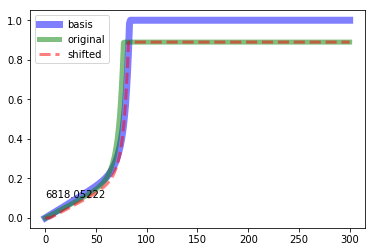

4.10532188416


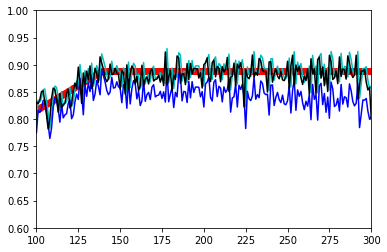

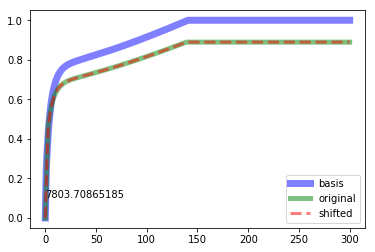

4.67149400711


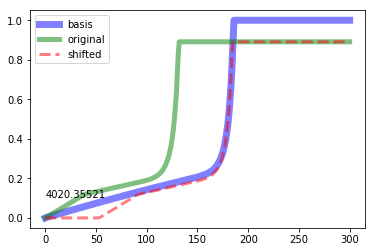

4.17382788658


In [156]:
start = time.time()

#Chi2OneSignal(np.multiply(base_data[54, 2, 0:], 0.5))
sig = base_data[54, 2, 0:]
sig = moving_avg_filter(sig)
sig = moving_avg_filter(sig)
sig = add_noise(sig, 0.02)
sig = add_exp_decay(sig)
sig = decay_correction(sig, 4400)
#sig = base_data[54, 2, 0:]
sig = base_data[54, 2, 0:]
Chi2OneSignal(sig, plot=True)

end = time.time()
print(end - start)

start = time.time()

#Chi2OneSignal(np.multiply(base_data[1, 2, 0:], 2))
sig = base_data[1, 2, 0:]
#plt.plot(sig, 'ro')
sig = moving_avg_filter(sig)
#plt.plot(sig, 'yo')
sig = moving_avg_filter(sig)
plt.plot(sig, 'ro')
sig = add_noise(sig, 0.02)
plt.plot(sig, 'c')
sig = add_exp_decay(sig)
plt.plot(sig, 'b')
sig = decay_correction(sig, 4400)
plt.plot(sig, 'k')
plt.xlim([100,300])
plt.ylim([0.6, 1])
plt.show()
sig = base_data[1, 2, 0:]
Chi2OneSignal(sig, plot=True)

end = time.time()
print(end - start)

start = time.time()

#Chi2OneSignal(np.multiply(base_data[100, 2, 0:], 1))
sig = base_data[100, 2, 0:]
sig = moving_avg_filter(sig)
sig = moving_avg_filter(sig)
sig = add_noise(sig, 0.02)
sig = add_exp_decay(sig)
sig = decay_correction(sig, 4400)
sig = base_data[100, 2, 0:]
Chi2OneSignal(sig, plot=True)

end = time.time()
print(end - start)

In [52]:
# IMPORT DATA
def ImportData():
    data = np.zeros((number_interactions_total, number_strips, number_samples))
    for i in range(0, number_interactions_total, 1):
        i = int(i)
        print(i)
        filename = "Strip_SS_" + str(i) + ".txt"
        print('processing... ' ,filename)
        rawdata = np.genfromtxt(filename, skip_header=1)
        # indicies = row, col
        strip0 = rawdata[:,6:7]
        strip1 = rawdata[:,7:8]
        strip2 = rawdata[:,8:9]
        strip3 = rawdata[:,9:10]
        strip4 = rawdata[:,10:11]
        strip5 = rawdata[:,11:12]

        for j in range(0, number_samples, 1):
            j = int(j)
            print(j)
            data[i][0][j] = strip0[j] # i = event_number, k=strip, j = number_sample
            data[i][1][j] = strip1[j]
            data[i][2][j] = strip2[j]
            data[i][3][j] = strip3[j]
            data[i][4][j] = strip4[j]
            data[i][5][j] = strip5[j]
    return data

In [53]:
def DownsampleData(data, sampling_interval):
    downsampled_data = data[0::sampling_interval]
    return downsampled_data


In [360]:
def PlotSignalGrid(data, event_num=0, interactions_per_event=[4,5,1]):
    signal0 = [0] * 301
    signal1 = [0] * 301
    signal2 = [0] * 301
    signal3 = [0] * 301
    signal4 = [0] * 301
    signal5 = [0] * 301
    n = 301  # in ns the time of the pulse
    interactions_already_counted = 0
    for l in range(event_num, event_num + 1, 1):
        startindex = 0
        print('start index ', startindex)
        interactions = interactions_per_event[l]
        # print('interactions ', interactions)
        if l == 0:
            interactions_already_counted = 0
        else:
            interactions_already_counted = int(np.sum(interactions_per_event[0:l]))
        # print('interactions_already_counted ', interactions_already_counted)
        for i in range(interactions_already_counted, number_interactions_total, 1):
            if i < interactions_already_counted + interactions:
                for j in range(0, number_samples, 1):
                    #if j == 10:
                        #print('j + startindex ', j + startindex)
                        #print('signal0 ', signal0[j + startindex])
                    signal0[j + startindex] = signal0[j + startindex] + data[i][0][j] # i = event_number, k=strip, j = number_sample
                    signal1[j + startindex] = signal1[j + startindex] + data[i][1][j]
                    signal2[j + startindex] = signal2[j + startindex] + data[i][2][j]
                    signal3[j + startindex] = signal3[j + startindex] + data[i][3][j]
                    signal4[j + startindex] = signal4[j + startindex] + data[i][4][j]
                    signal5[j + startindex] = signal5[j + startindex] + data[i][5][j]

    fig, axes = plt.subplots(nrows=2, ncols=3)
    axes[0, 0].set_title('strip 0')
    axes[0, 1].set_title('strip 1')
    axes[0, 2].set_title('strip 2')
    axes[1, 0].set_title('strip 3')
    axes[1, 1].set_title('strip 4')
    axes[1, 2].set_title('strip 5')

    axes[0, 0].set_ylim(ymin=-1)
    axes[0, 1].set_ylim(ymin=-1)
    axes[0, 2].set_ylim(ymin=-1)
    axes[1, 0].set_ylim(ymin=-1)
    axes[1, 1].set_ylim(ymin=-1)
    axes[1, 2].set_ylim(ymin=-1)
    axes[0, 0].set_ylim(ymax=1)
    axes[0, 1].set_ylim(ymax=1)
    axes[0, 2].set_ylim(ymax=1)
    axes[1, 0].set_ylim(ymax=1)
    axes[1, 1].set_ylim(ymax=1)
    axes[1, 2].set_ylim(ymax=1)

    axes[0, 0].plot(signal0)
    axes[0, 1].plot(signal1)
    axes[0, 2].plot(signal2)
    axes[1, 0].plot(signal3)
    axes[1, 1].plot(signal4)
    axes[1, 2].plot(signal5)
    fig.tight_layout()
    plt.show()

In [361]:
def PlotSignalGridSim(data, event_num = 0):

    signal0 = data[event_num][0][0:301] #i = event_number, k=strip, j = number_sample
    signal1 = data[event_num][1][0:301]
    signal2 = data[event_num][2][0:301]
    signal3 = data[event_num][3][0:301]
    signal4 = data[event_num][4][0:301]
    signal5 = data[event_num][5][0:301]

    fig, axes = plt.subplots(nrows=2, ncols=3)
    axes[0, 0].set_title('strip 0')
    axes[0, 1].set_title('strip 1')
    axes[0, 2].set_title('strip 2')
    axes[1, 0].set_title('strip 3')
    axes[1, 1].set_title('strip 4')
    axes[1, 2].set_title('strip 5')

    axes[0, 0].set_ylim(ymin=-1)
    axes[0, 1].set_ylim(ymin=-1)
    axes[0, 2].set_ylim(ymin=-1)
    axes[1, 0].set_ylim(ymin=-1)
    axes[1, 1].set_ylim(ymin=-1)
    axes[1, 2].set_ylim(ymin=-1)
    axes[0, 0].set_ylim(ymax=1)
    axes[0, 1].set_ylim(ymax=1)
    axes[0, 2].set_ylim(ymax=1)
    axes[1, 0].set_ylim(ymax=1)
    axes[1, 1].set_ylim(ymax=1)
    axes[1, 2].set_ylim(ymax=1)

    axes[0, 0].plot(signal0)
    axes[0, 1].plot(signal1)
    axes[0, 2].plot(signal2)
    axes[1, 0].plot(signal3)
    axes[1, 1].plot(signal4)
    axes[1, 2].plot(signal5)
    fig.tight_layout()
    plt.show()

In [363]:
def test_shifter():
    signal0 = data[event_num][0][0:301]
    shift_signal(signal0, signal0)
    signal0_edited = list(np.linspace(0, signal1[0], 10))
    signal0_edited.extend(signal0[0:-10])
    shift_signal(signal0, signal0_edited)
    signal0_edited = list(np.linspace(0, signal1[0], 50))
    signal0_edited.extend(signal0[0:-50])
    shift_signal(signal0, signal0_edited)
    signal0_edited = list(signal0[(10):])
    signal0_edited.extend([float(signal0[-1])] * (10))
    shift_signal(signal0, signal0_edited)
    signal0_edited = list(signal0[(50):])
    signal0_edited.extend([float(signal0[-1])] * (50))
    shift_signal(signal0, signal0_edited)

def shift_left(signal0, i):
    signal0_edited = list(np.linspace(0, signal0[0], i))
    signal0_edited.extend(signal0[0:-i])
    return signal0_edited


def shift_right(signal0, i):
    signal0_edited = list(signal0[(i):])
    signal0_edited.extend([float(signal0[-1])] * (i))
    shift_signal(signal0, signal0_edited)
    return signal0_edited

In [364]:
def chi2_compare_all_strips(event_num):
    fig, axes = plt.subplots(nrows=2, ncols=3)
    axes[0, 0].set_title('strip 0')
    axes[0, 1].set_title('strip 1')
    axes[0, 2].set_title('strip 2')
    axes[1, 0].set_title('strip 3')
    axes[1, 1].set_title('strip 4')
    axes[1, 2].set_title('strip 5')
    axes[0, 0].set_ylim(ymin=-1)
    axes[0, 1].set_ylim(ymin=-1)
    axes[0, 2].set_ylim(ymin=-1)
    axes[1, 0].set_ylim(ymin=-1)
    axes[1, 1].set_ylim(ymin=-1)
    axes[1, 2].set_ylim(ymin=-1)
    axes[0, 0].set_ylim(ymax=1)
    axes[0, 1].set_ylim(ymax=1)
    axes[0, 2].set_ylim(ymax=1)
    axes[1, 0].set_ylim(ymax=1)
    axes[1, 1].set_ylim(ymax=1)
    axes[1, 2].set_ylim(ymax=1)

    chi2_values = []
    for strip_num in range(0, 6, 1):
        sig_ref = data[0][strip_num][0:301]
        sig_raw = shift_left(data[event_num][strip_num][0:301], 50)
        sig_shifted, chi2 = shift_signal(sig_ref, sig_raw)
        chi2_values.append(chi2)
        if strip_num == 0:
            j = 0
            k = 0
        if strip_num == 1:
            j = 0
            k = 1
        if strip_num == 2:
            j = 0
            k = 2
        if strip_num == 3:
            j = 1
            k = 0
        if strip_num == 4:
            j = 1
            k = 1
        if strip_num == 5:
            j = 1
            k = 2
        plt.figure(1)
        axes[j, k].plot(sig_ref, 'b-', linewidth=7.0, alpha=0.5, label = 'basis')
        axes[j, k].plot(sig_raw, 'g-', linewidth=5.0, alpha=0.5,label = 'original')
        axes[j, k].plot(sig_shifted, 'r--', linewidth=3.0, alpha=0.5, label = 'shifted')
        axes[j, k].text(0, 0.1, chi2_values[strip_num])
    print(chi2_values)
    plt.legend()
    fig.tight_layout()
    plt.savefig('sig0_leftshift.pdf')
    plt.show()

In [365]:
def moving_avg_filter(x): #(smooths with width of 1, 3 times)
    N = 3
    x = np.convolve(x, np.ones((N,))/N, mode='same')
    return x

4400


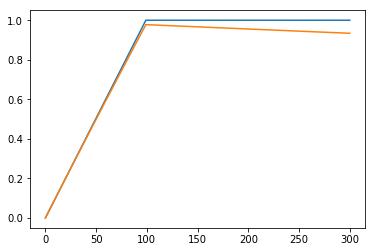

In [366]:

#C = 1*10**(-12)
#R = 1*10**16
#tau = R*C 

#Qout = Qs * 1/2 * tm/ tcs     Radeka
#Qs = charge on electrode, tm = time duration of measurement, tcs = carrier transit time through channel
#dIout/ dQin = 1/tc, tc = transit time,  


tau = 4400
print(tau)
def add_exp_decay(sig):
    #sig = np.multiply(sig, 1000)
    for i in range(0, len(sig) ,1):
        sig[i] = sig[i] * np.exp(-i/tau)
    return sig
    #1./tau*np.exp(-t/tau)


sig = make_sample_signal()
#sig = np.multiply(sig, 1/C)
plt.plot(sig)
sig = add_exp_decay(sig)
plt.plot(sig)
#plt.xlim([50,100])
plt.show()

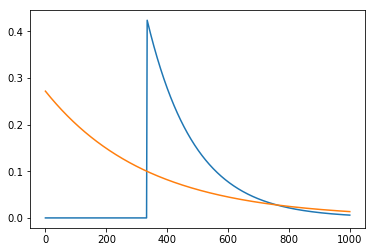

In [367]:
def func(x, a, c, d):
    return a*np.exp(-c*x)+d

def Decay(t,tau,t0):
    ''' Decay expoential and step function '''
    return 1./tau*np.exp(-t/tau) * 0.5*(np.sign(t-t0)+1.0)

def ExpDecay(t,tau,t0):
    ''' Decay expoential and step function '''
    return 1./tau*np.exp(-t/tau) * 0.5 #* 0.5*(np.sign(t-t0)+1.0)

tau = 2.344
t0 = 0
t = np.linspace(-10,10,1000) 
t_response = np.linspace(-5,10,1000)# Time domain of response function

r = Decay(t_response,tau,t0)


tau = 5
t0 = 0
t = np.linspace(-10,10,1000) 
t_response = np.linspace(-5,10,1000)# Time domain of response function

s = ExpDecay(t_response,tau,t0)

plt.plot(r)
plt.plot(s)
plt.show()


In [19]:
# event_number is related to the delta_x. delta_y in event sim
number_interactions_total = 9
number_strips = 6
number_samples = 301
# times = GetTimeBetweenDecays(10)
# print(times)
# times = [0, 1000, 2000, 3000]
###data = ImportData()
##PlotSignalGridSim(data, 0)
##PlotSignalGridSim(data, 1)
##PlotSignalGridSim(data, 2)
##PlotSignalGridSim(data, 3)
###event_num = 0
###signal0 = data[event_num][0][0:301] #i = event_number, k=strip, j = number_sample
signal0 = sig0
# signal1 = data[event_num][1][0:301]
# signal2 = data[event_num][2][0:301]
# signal3 = data[event_num][3][0:301]
# signal4 = data[event_num][4][0:301]
# signal5 = data[event_num][5][0:301]
# align starting points of signal
#test_shifter()
xdata = signal0
xerror = noise_level = 0.02
signal0_1 = add_noise(sig0, noise_level) # signal0 #data[1][0][0:301]
signal0_2 = add_noise(sig0, noise_level) # signal0 #data[2][0][0:301]
signal0_1, chi2_0_1 = shift_signal(signal0, signal0_1)
signal0_2, chi2_0_2 = shift_signal(signal0, signal0_2)
print('chi ',chi2_0_1)
print(chi2_0_2)
signal0_1 = data[1][0][0:301]
signal0_2 = data[2][0][0:301]
signal0_1, chi2_1_2 = shift_signal(signal0_1, signal0_2)
print(chi2_1_2)
# adjust height of signal


chi2_compare_all_strips(0)
#chi2_compare_all_strips(0)
#
#chi2_compare_all_strips(1)
#2 interactions?
sys.exit()

shift_signal(signal0, signal1)
shift_signal(signal0, signal2)
shift_signal(signal0, signal3)
shift_signal(signal0, signal4)
shift_signal(signal0, signal5)
sys.exit()


#chi_squared = np.sum(((sig-sig0)/xerror)**2)
#reduced_chi_squared = (chi_squared)/(len(xdata)-len(xdata) + 1)

# calculate chisq of signals

# calculate position resolution of signals


sys.exit()


NameError: name 'sig0' is not defined

In [20]:
# 